### Load libraries

In [1]:
library(Seurat)
library(stringr)
library(viridis)
library(ggplot2)
library(cowplot)
library(cluster)
library(data.table)
library(foreach)
library(doParallel)
library(proxy)
library(ComplexHeatmap)
library(circlize)
library(igraph)
library(qvalue)
library(dplyr)
library(viridis)
library(VGAM)
library(forcats)
library(grDevices)
library(graphics)
library(RColorBrewer)
library(pheatmap)
library(Cairo)
library(slingshot)
library(ggsci)
library(scales)
set.seed(seed = 42)

Attaching SeuratObject

Loading required package: viridisLite

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.14
CRA

### Load functions

In [2]:
#Basic functions
tableread_fast = function(i, header=TRUE, quote="", sep=","){
  tmp = fread(i, header=header, sep=sep, quote=quote, nThread=32)
  tmp = as.data.frame(tmp)
  return(tmp)
}

createEmptyDf = function( nrow, ncol, colnames = c() ){
  data.frame( matrix( vector(), nrow, ncol, dimnames = list( c(), colnames ) ) )
}

In [3]:
##Plot clones in dimentional reduction plot (DimPlot)
#seu: Seurat object / tmp2: identifier of plotting cells

PlotClones = function(seu, tmp2, name.output, meta.data, clone_plot, reduction, width, height, size){
    #Exctract names for cells in plot
    tmp_raw <- as.vector(row.names(meta.data))
    #Extract colors for plot
    p2 = Seurat::DimPlot(object = seu, reduction = reduction, pt.size = 0.1)
    orig_ident_build = ggplot2::ggplot_build(p2)
    orig_ident_build = orig_ident_build$data[[1]]
    orig_ident_build =  orig_ident_build[order(orig_ident_build$group), ]
    ident.cols = unique(orig_ident_build$colour) # Get a vector of unique colors
    names(ident.cols)=c(0:(max(as.numeric(seu@active.ident)-1)))

    #Extract x- and y- axis information for DimPlot
    xmin <- min(orig_ident_build$x)-0.5
    xmax <- max(orig_ident_build$x)+0.5
    ymin <- min(orig_ident_build$y)-0.5
    ymax <- max(orig_ident_build$y)+0.5
    x_label_min <- floor(xmin/10)*10
    x_label_max <- ceiling(xmax/10)*10
    y_label_min <- floor(ymin/10)*10
    y_label_max <- ceiling(ymax/10)*10

    #Dimplot
    p1 <- DimPlot(object = seu, label = FALSE,
                    cells = tmp2,
                    reduction = reduction,
                    cols = ident.cols,
                    pt.size = size) + 
        NoLegend() +
        scale_x_continuous(limits = c(xmin,xmax), breaks= seq(x_label_min,x_label_max,10)) +
        scale_y_continuous(limits = c(ymin,ymax), breaks= seq(y_label_min,y_label_max,10)) +
        theme(axis.title = element_blank(), 
              axis.text = element_blank(),
             axis.line = element_line(size = 0.2))
    
      save_plot(file = name.output, plot_grid(p1, ncol=1, nrow=1), device="tiff", 
                units="in", dpi = 300, base_width = width, base_height = height, limitsize=FALSE)
}

In [4]:
modify_vlnplot_score <- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          plot.title= element_blank(),
          axis.title.x = element_blank(),
          axis.text.x =  element_text(family = "Arial", size = 8, angle = 0, colour = "black", face = "plain"), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_blank(), 
          axis.text.y = element_text(family = "Arial", size = 6, angle = 0, colour = "black", face = "plain"), 
          plot.margin = plot.margin ) 
  return(p)
}

### Load data

In [13]:
#Call Seurat object after merging scTCR data
load("results/preprocess/Pooled_clust_pseudotime_Signature_scTCR.rda")


### Figure 3

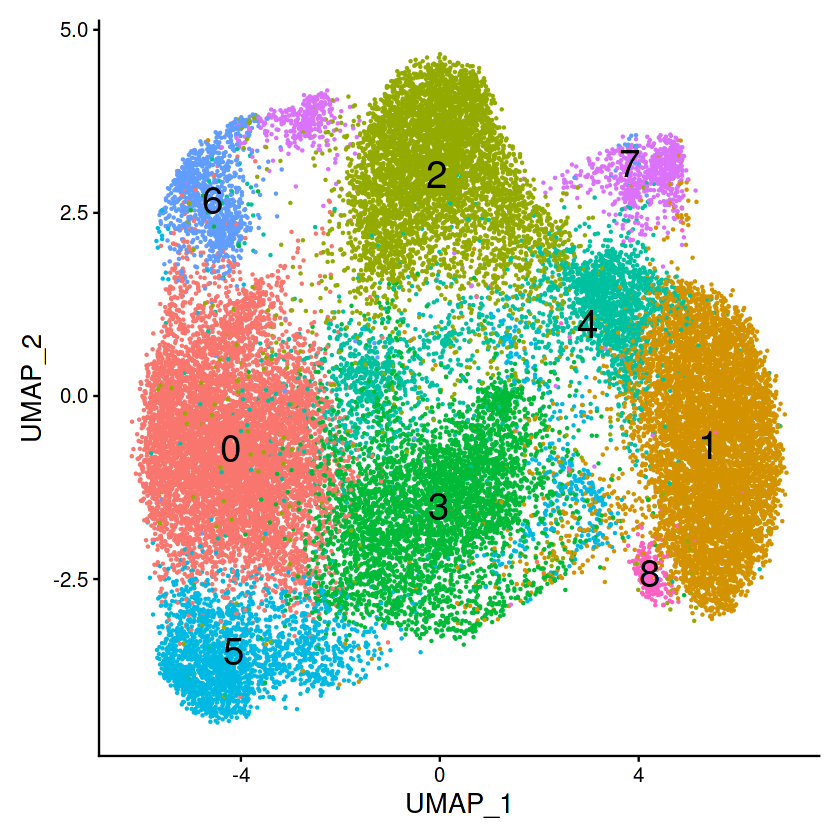

In [14]:
###Figure 3B, Protting the result of dimentional reduction

dir.name <- "results/plotting/3B.UMAP"
file.name <- "Fig3B.umap.tiff"

################################# Processing layer ##########################################
dir.create(dir.name, recursive = TRUE)

#Output twice size of figure, compress after pasting in the powerpoint.
p1 = DimPlot(object = seu, reduction = "umap", label = TRUE, label.size = 8, pt.size = 0.2) +
      theme(axis.title.x = element_text(size=16, colour = 1, family = "Arial"), 
            axis.title.y = element_text(size=16, colour = 1, family = "Arial"), 
            axis.text.x = element_text(size=12, colour = 1, family = "Arial"), 
            axis.text.y = element_text(size = 12, colour = 1, family = "Arial")) +
      theme(panel.border = element_rect(fill = NA, size = 1.5)) 

p1 = p1 + theme(legend.position = 'none')
name.output <- str_c(dir.name, file.name, sep = "/")
save_plot(file = name.output, plot(p1), device="tiff", 
              units="in", dpi = 300, base_width = 4.6, base_height = 4.6, limitsize=FALSE)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



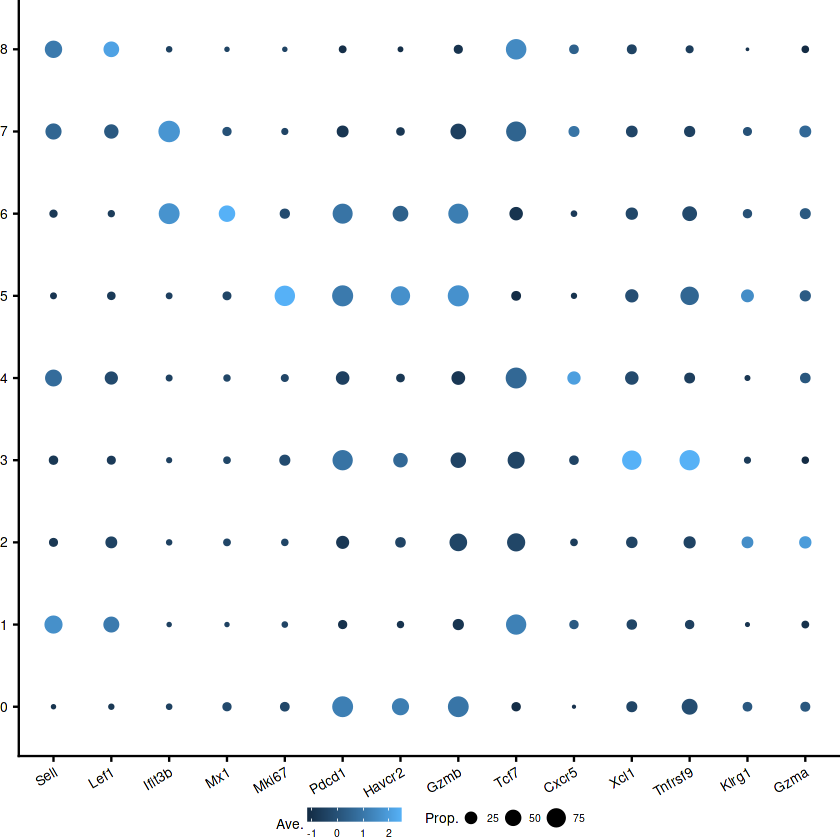

tiff 
   3

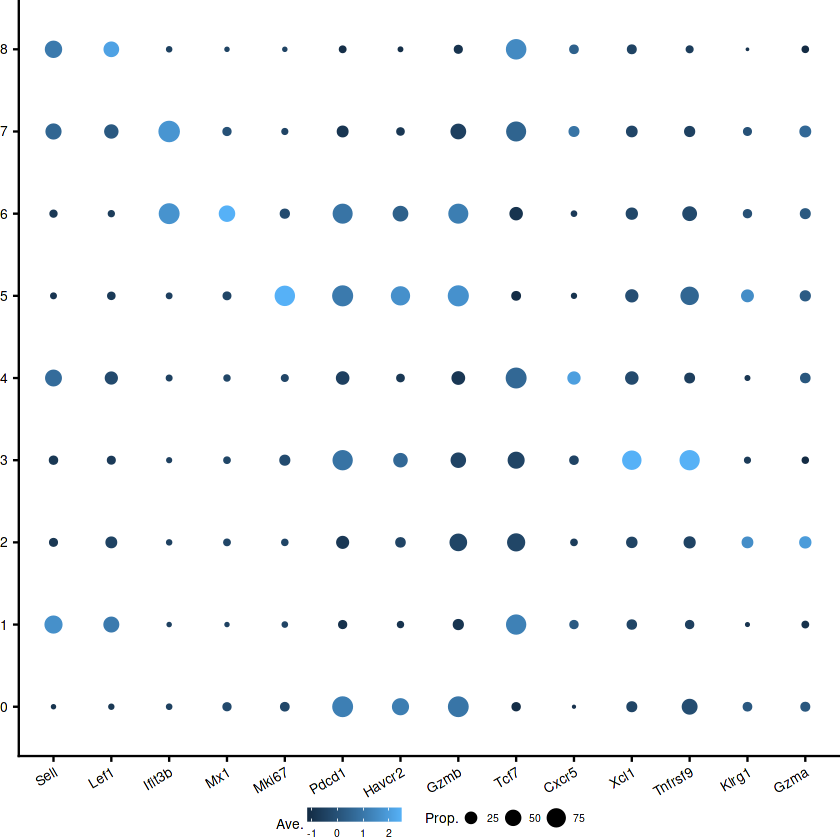

In [15]:
###Figure 3C, Baloon plot for marker genes

dir.name <- "results/plotting/3C.Baloon"
file.name <- "Fig3C.BaloonPlot.tiff"
genes <- c("Sell", "Lef1", #cluster1
           "Ifit3b", "Mx1", #cluster6,7
           "Mki67", #cluster5
           "Pdcd1", "Havcr2", "Gzmb", #cluster0
           "Tcf7", "Cxcr5", #cluster4
           "Xcl1", "Tnfrsf9", #cluster3
           "Klrg1", "Gzma" #cluster2
           )

#breaks for legend color bar
bar.cont <- c(-1, 0, 1, 2)
bar.list <- list(bar.cont)

################################# Processing layer ##########################################
dir.create(dir.name)
    
ppi <- 300
name.output <- str_c(dir.name, file.name, sep = "/")
p <- DotPlot(seu, features = genes, cols = c("lightgrey", "blue"),
            dot.min = 0, dot.scale = 5,
            scale.by = "size", scale.min = NA, scale.max = NA) +
      theme(axis.title = element_blank(), 
            axis.text.y = element_text(size=8, colour = 1, family = "Arial"),
            axis.text.x = element_text(size=8, colour = 1, family = "Arial", angle = 30, hjust = 1)) + 
            scale_colour_continuous(breaks =bar) +
      theme(panel.border = element_rect(fill = NA, size = 0.1),
            legend.position = "bottom",
            legend.key.width = unit(0.4, "cm"),
            legend.key.height = unit(0.3, "cm"),
            legend.justification = "top",
            legend.text = element_text(size=6, colour = 1, family = "Arial"),
            legend.title = element_text(size=8, colour = 1, family = "Arial"),
            legend.margin=margin(0,0,0,0),
            legend.box.margin=margin(-10,-5,0,-5),
            plot.margin = unit(c(0, 0, 0, 0), "cm")) +
        guides(colour = guide_colourbar(order=1, breaks=seq(-2,2,1)),
               size = guide_legend(order=2))
p$guides$colour$title <- "Ave."
p$guides$size$title <- "Prop."
file.name <- str_c(dir.name, file.name, sep="/")
save_plot(file = file.name, plot(p), device="tiff", 
              units="in", dpi = 600, base_width = 3.8, base_height = 2.1, limitsize=FALSE)
plot(p)
dev.off()

In [16]:
#Figure3D: Violin plot for Signature Score

#Specify clone table merged with dLN overlap status
dir.name <- "results/plotting/3D.Signature"
#Specify clone table merged with dLN overlap status
sample.name <- "Signature.Violin.tiff"
Sig_array <- c("Tumor.Prog1", "Tumor.Term1", "TexKLR1")

############################# Processing layer ######################################
dir.create(dir.name)
    
for(Sig in Sig_array){
    #Violin Plot
    file.name <- str_c(dir.name, Sig, sep='/') %>% str_c(sample.name, sep = ".")
    ppi <- 600
    tiff(file.name, width=1.5*ppi, height=1.1*ppi, res=ppi)
    p <- modify_vlnplot_score(obj = seu, feature = Sig, pt.size = 0)
    plot(p)
    dev.off()
}

In [17]:
###Figure 3E: Pseudotime Analysis between clusters

dir.name <- "results/plotting/3E.Pseudotime"
red.use <- "umap"

############################# Processing layer ######################################
dir.create(dir.name)

#Plot pseudotime in dimentional reduction
name.output=str_c(dir.name, "Pseudotime.tiff", sep = "/")
ppi <- 600
tiff(name.output, width=3.6*ppi, height=2.6*ppi, res=ppi)
#Output twice size of figure, compress after pasting in the powerpoint.
p <- FeaturePlot(object = seu, features = "pseudotime", cols = c("#800080", "#ffee00"), reduction = red.use, pt.size = 0.1) +
          theme(plot.title = element_blank(), 
                axis.title.x = element_blank(), 
                axis.title.y = element_blank(), 
                axis.text.x = element_text(size=12, colour = 1, family = "Arial"), 
                axis.text.y = element_text(size = 12, colour = 1, family = "Arial"),
               legend.title = element_text(size=12, family = "Arial"),
               legend.text = element_text(size=12, family = "Arial"),
               legend.key.width = unit(0.5, "cm")) +
          theme(panel.border = element_rect(fill = NA, size = 0.75)) 
plot(p)
dev.off()

png 
  2

In [18]:
#Figure3F: Plot cells in treatment in Dimplot

sample.name <- ""
dir.name <- "results/plotting/3F.PlotTreatment"
red.use <- "umap" #dimentional reduction used
Treats <- c("aCD4", "Control", "aPDL1")

##################### Processing layer #############################################################
dir.create(dir.name)

#Load meta data
meta.data <- as.data.frame(seu@meta.data)
tmp_raw <- as.vector(row.names(meta.data))
meta.data$ID <- str_split(row.names(meta.data), pattern = "_", simplify = TRUE)[,2]

for(treat in Treats){
    #Extract cell names for Dimplot/Pie chart
    data_sub <- dplyr::filter(meta.data, sample.origin == treat)
    clone.id <- as.vector(row.names(data_sub))
    tmp2 = tmp_raw %in% clone.id

    #Output name
    name.output <- str_c(dir.name, treat, sep = "/") %>% str_c("Dimplot.tiff", sep = ".")
    PlotClones(seu, tmp2, name.output, meta.data, clone_plot, red.use, 2, 2, 0.1)
}

#Summarize cluster distribution
summary.table <- table(meta.data$sample.origin, meta.data$seurat_clusters)
name.output <- str_c(dir.name, "Treat.distribution.summary.csv", sep = "/")
write.csv(summary.table, name.output)

In [19]:
#Figure3G: Plot clones of Oligoclonal and Polyclonal fraction in Dimplot

modules <- c("Oligo", "Poly")
dir.name <- "results/plotting/3G.ClonePlot"
red.use <- "umap" #dimentional reduction used
#Specify clone table merged with dLN overlap status
basename.clone.table <- "scTCR.dLNOL.csv"
Treats <- c("aCD4", "Control", "aPDL1")

############################# Processing layer ######################################
dir.create(dir.name)

for(treat in Treats){
    #Call clone table merged with dLN overlap status (Stored in "scTCR_WGCNA_combine" directory)
    name.clone.table <- str_c("results/preprocess/scTCR_analysis", treat, sep = "/") %>%
        str_c(basename.clone.table, sep = ".")
    clone_within_cluster <- read.csv(name.clone.table, header = TRUE)

    #Call metadata and extract cell names
    meta.data <- as.data.frame(seu@meta.data)
    tmp_raw <- as.vector(row.names(meta.data))    

    #Output twice size of figure, compress after pasting in the powerpoint.
    for(i in modules){
        #Extract clones in each subset
        clone_plot <- dplyr::filter(clone_within_cluster, OL == i)
        clone_names <- clone_plot$names

        #Extract cell names for Dimplot
        data_sub <- dplyr::filter(meta.data, clone.id.TCRb %in% clone_names) %>% dplyr::filter(sample.origin == treat)
        clone.id <- as.vector(row.names(data_sub))
        tmp2 = tmp_raw %in% clone.id

        #Output
        name.output <- str_c(dir.name, treat, sep = "/") %>% str_c(i, "clone.plot.tiff", sep = ".")
        PlotClones(seu, tmp2, name.output, meta.data, clone_plot, red.use, 2, 2, 0.1)
    }
}

In [20]:
###Plot bar graph for cluster distribution
Group_bar <- function(col.vector, data, dir.name, sample.name2, modules){
    #Change table format
    data.table <- as.data.frame(t(data[2:ncol(data)]))
    names(data.table) <- data[,1]
    clusters <- str_remove(row.names(data.table), "X")
    data.table$clust <- factor(clusters, levels = clusters)
    data.table <- tidyr::gather(data = data.table, 1:3, key = Treat, value = Number)
    data.table$Treat <- factor(data.table$Treat, levels = modules)

    #Plot bar graph
    file.name=str_c(dir.name, sample.name2, sep = "/") %>% str_c("Group_dist.tiff", sep='.')
    ppi <- 600
    g <- ggplot(data.table, aes(x = clust, y = Number, fill = Treat)) +
        scale_fill_manual(values=col.vector) +
        geom_bar(stat = "identity", position = "fill") +
        labs(y="Prop. in cluster") +
        scale_y_continuous(labels = percent) +
        theme_classic() + 
        theme(plot.title = element_blank(), 
              panel.background = element_rect(fill = "transparent",color = NA),
              plot.background = element_rect(fill = "transparent",color = NA),
                axis.title.x = element_blank(), 
                axis.title.y = element_text(size=8, family = "Arial"), 
                axis.text.x = element_blank(), 
                axis.text.y = element_text(size=6, family = "Arial")) +
        guides(fill = "none") 
    save_plot(file = file.name, plot(g), device="tiff", 
              units="in", dpi = 600, base_width = 2.2, base_height = 1, limitsize=FALSE)
}

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(clusts)` instead of `clusts` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Warning message:
“Removed 3 rows containing missing values (geom_bar).”
Warning message:
“Removed 3 rows containing missing values (geom_bar).”


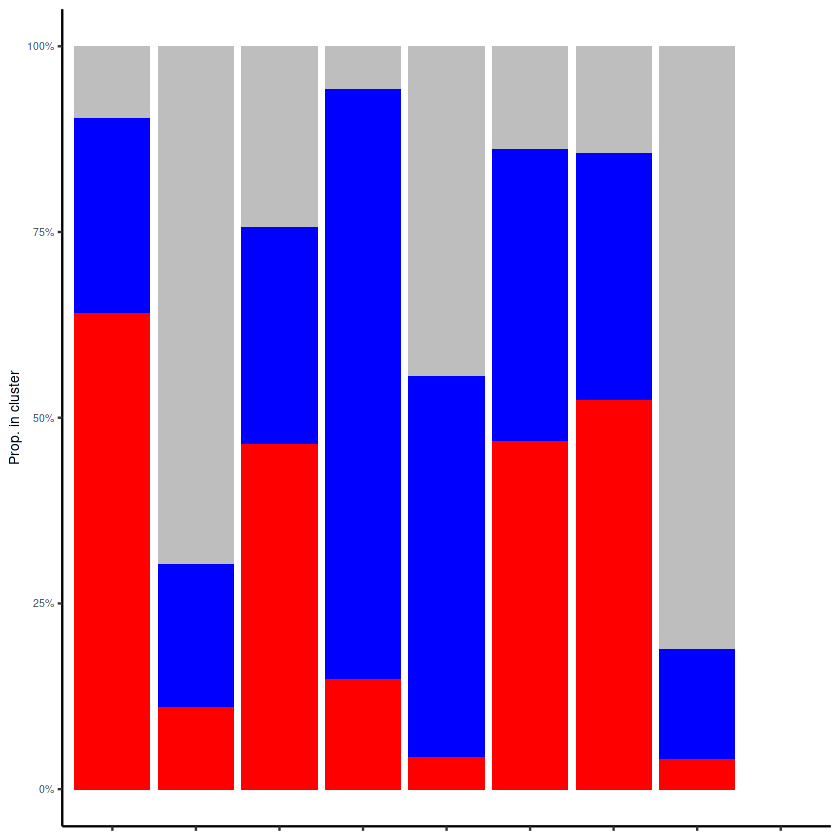

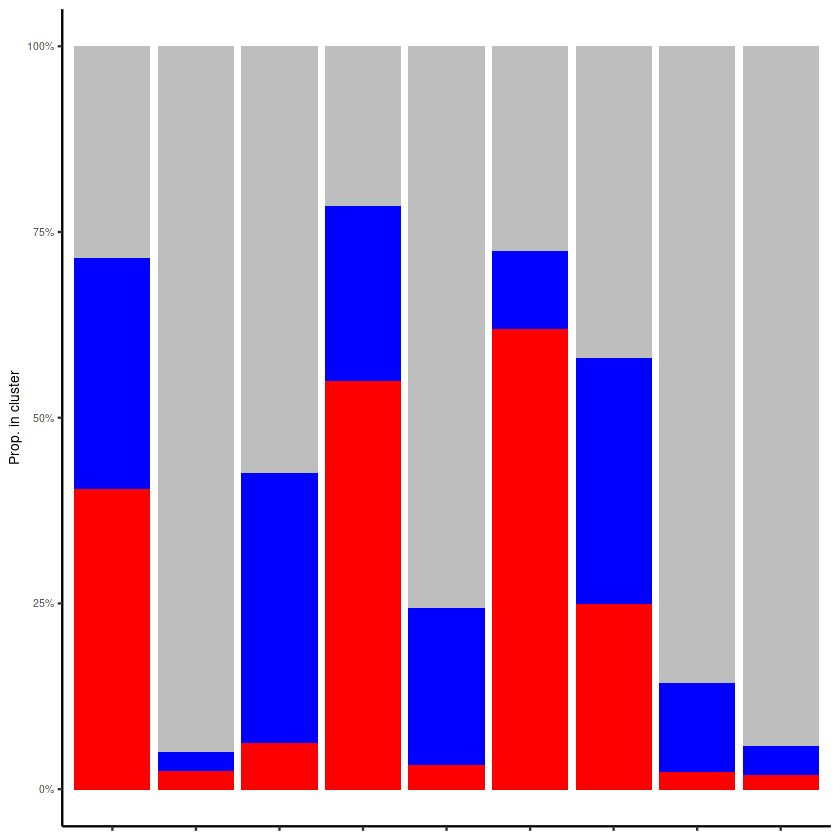

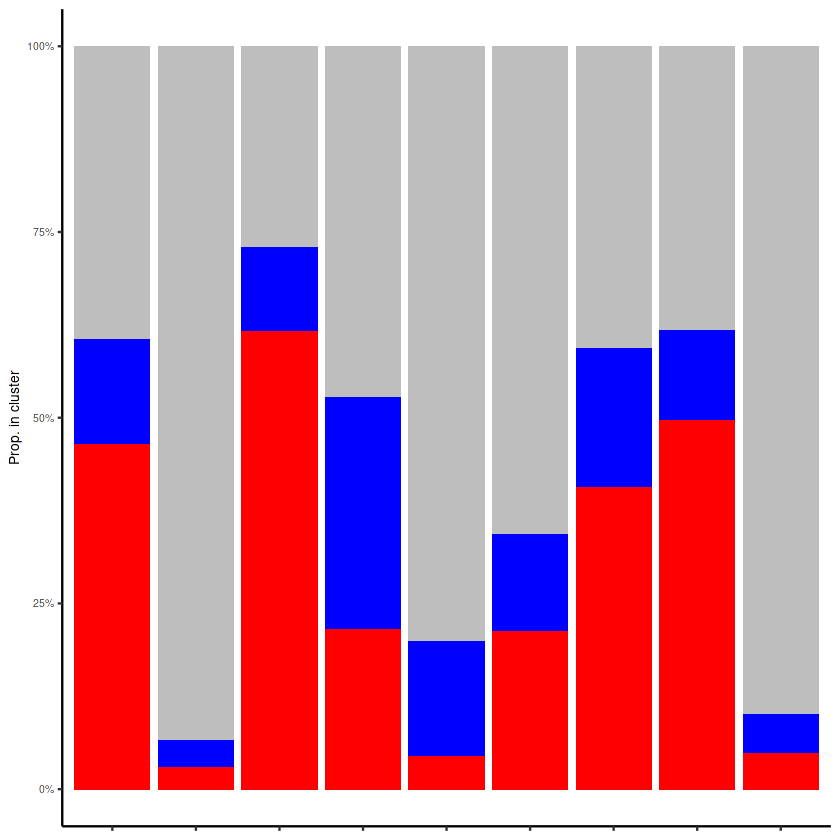

In [21]:
#Figure3H: Plot proportion of Oligoclonal / Polyclonal fraction in each cluster

sample.name <- ""
modules <- c("nonOL", "Poly", "Oligo")
treats <- c("aCD4", "aPDL1", "Control")
dir.name <- "results/plotting/3H.OLClonePlot"

############################# Processing layer ######################################
dir.create(dir.name, recursive = TRUE)
 
for(treat in treats){
    #Call clone table merged with dLN overlap status (Stored in "scTCR_WGCNA_combine" directory)
    name.clone.input <- str_c("results/preprocess/scTCR_analysis", treat, sep = "/") %>% str_c("scTCR.dLNOL.csv", sep = ".")
    clone_within_cluster <- read.csv(name.clone.input, header = TRUE)
        
    #Generate table for distribution plot
    table <- dplyr::filter(clone_within_cluster, treat == treat) %>% dplyr::select(starts_with("X"))
    clusts <- names(table)
    table$OL <- clone_within_cluster$OL
    data <- as.data.frame(dplyr::group_by(table, OL) %>% dplyr::summarize(dplyr::across(clusts, sum)))
        
    sample.name2 <- str_c(sample.name, treat)
        
    ###Plot bar graph for Group/treat distribution
    col.vector <- c("grey", "blue", "red")
    names(col.vector) = modules
    Group_bar(col.vector, data, dir.name, sample.name2, modules)
}

In [22]:
#Figure 3I,J: Correlation analysis between gene score and clone size
#Input; scTCR_analysis/clone_within_cluster.dLNOL.csv

file.basename  <- "scTCR.dLNOL.csv"
dir.input <- "results/preprocess/scTCR_analysis"
dir.name <- "results/plotting/3IJ.Correlation"
treats <- c("aCD4", "aPDL1", "Control")
scores <- c("Tumor.Prog1", "Tumor.Term1")

############################# Processing layer ######################################
dir.create(dir.name)

output.table <- data.frame()
for(treat in treats){ 
    #Load clone table
    name.input <- str_c(dir.input, treat, sep = "/") %>% str_c(file.basename, sep = ".")
    d <- read.csv(name.input, header = TRUE)
    d_sub <- dplyr::select(d, c("temp_freq", scores, "OL"))
    d_sub <- dplyr::filter(d_sub, temp_freq > 0.001)
    d_sub <- dplyr::filter(d_sub, OL %in% c("Poly", "Oligo"))

    axis_x <- "temp_freq"
    axis_y <- scores

    #Convert frequency to percentage
    d_sub$temp_freq <- d_sub$temp_freq*100

    #Calculate correation coefficient
    col.names <- c("pvalue", "rvalue", "cor_abs")
    output <- createEmptyDf(length(axis_y), length(col.names), colnames = col.names )
    for(j in 1:length(axis_y)){
        #Extract data
        y_param <- axis_y[j]
        d_sub2 <- dplyr::select(d_sub, c("OL", axis_x, y_param))
        names(d_sub2) <- c("OL", "x_axis", "y_axis")

        #Calculate correlation coefficient
        result.name <- str_c(dir.name, "Genescore.correlation.txt", sep = "/")
        cor_t <- cor.test(log10(d_sub2$x_axis), d_sub2$y_axis, use="pairwise", method="pearson")

        #Record pvalues
        output[j,1] <- cor_t$p.value
        output[j,2] <- cor_t$estimate
        output[j,3] <- abs(cor_t$estimate)
    }
    output$param <- axis_y
    output$condition <- treat
    
    output.table <- rbind(output.table, output)

    for(j in scores){
        d_sub2 <- dplyr::select(d_sub, c("OL", axis_x, j))
        names(d_sub2) <- c("OL", "x_axis", "y_axis")
        ppi <- 600
        name_out <- str_c(dir.name, treat, sep = "/") %>% str_c("x", axis_x, "y", j, "tiff", sep = ".")
        tiff(name_out, width=0.9*ppi, height=1*ppi, res=ppi)
        p <- ggplot(d_sub2, aes(x=x_axis, y=y_axis, colour=OL)) +
            scale_colour_manual(values=c(Poly="blue", Oligo="red"))+
            geom_point(size=0.4) +
            scale_x_log10() +
              theme_bw(base_size = 6) +
              theme(
                axis.title.x=element_blank(), axis.title.y=element_blank(),
                axis.text.x = element_text(size=6, family="Arial"),
                axis.text.y = element_blank()) +
              guides(colour=FALSE)
        plot(p)
        dev.off()
    }
}

name.output <- str_c(dir.name, "correlation.value.csv", sep = "/")
write.csv(output.table, name.output)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(scores)` instead of `scores` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(axis_x)` instead of `axis_x` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(y_param)` instead of `y_param` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(j)` instead of `j` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Warning message:
“`guides(<scale

### Figure S2

In [24]:
###Figure S2A: Marker Gene Heatmap

#Specify Merker gene list
dir.input <- "results/preprocess/Seurat_plot_Clustering"
file.name <- "PooledALLmarkers_minpct0.1_Adj_p0.05.txt"

top_count <- 5 #Number of genes per cluster
dir.name <- "results/plotting/S2A"

############################# Processing layer ######################################
dir.create(dir.name)

name.input <- str_c(dir.input, file.name, sep = "/")
seu.markers = read.table(name.input, header = TRUE)

#Extract genes for plotting
top10 = seu.markers %>% group_by(cluster) %>% top_n(top_count, avg_log2FC)
top10 = as.data.frame(top10)
top10  = top10 [!duplicated(top10$gene),]
top10 = top10 %>% arrange(desc(avg_log2FC))  %>% arrange(cluster)
top10 = as.data.frame(top10)

#Output heatmap
file.name <- paste(dir.name, "S2A.MarkerHeatmap.tiff", sep = "/")
p <- DoHeatmap(seu, features = top10$gene, disp.min = -2.5, disp.max = 2.5,
               size = 3, angle = 0) +
        theme(legend.position = 'bottom',
             axis.text.y = element_text(size=6, family="Arial"),
             legend.title = element_text(size=8, family="Arial"),
             legend.key.height = unit(0.33, 'cm'),
             legend.text = element_text(size=6, family="Arial"),
             legend.box.margin=margin(-20,-5,0,-5)) +
        guides(colour=FALSE)
ggsave(file = file.name, plot = p, device="tiff", units="in", dpi = 300,
       width = 6.4, height = 4.5, limitsize=FALSE)


Warning message in dir.create(dir.name):
“'results/plotting/S2A' already exists”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


In [25]:
###Figure S2B: Calculate clonality of TCR repertoire per clusters

#Specify clone table merged with dLN overlap status
output.basename <- "clonality.csv"
input.basename  <- "scTCR.dLNOL.csv"
dir.input <- "results/preprocess/scTCR_analysis"
dir.name <- "results/plotting/S2B.Clonaloity"
treats <- c("aCD4", "aPDL1", "Control")

############################# Processing layer ######################################
dir.create(dir.name)

outputs <- data.frame()
for(treat in treats){  
    name.input <- str_c(dir.input, treat, sep = "/") %>% str_c(input.basename, sep = ".")
    d <- read.csv(name.input, header = TRUE)
    
    #Extract cluster distribution information
    d_clusts <- dplyr::select(d, starts_with("X"))
    clust.array <- names(d_clusts)
    
    #Calculate clonality
    output <- data.frame()
    for(i in 1:length(clust.array)){
      clust <- clust.array[i]
      d_sub <- select(d, clust)
      names(d_sub) <- "count"
      d_sub <- filter(d_sub, count > 0)
      d_sub$freq <- d_sub$count / sum(d_sub$count)

      ##Calculate median and count clonotypes
      l <- length(d_sub$freq)
      count <- sum(d_sub$count)

      #Calculate 1-Pielou clonality (only calculate when clone count > 10)
        if(l > 10){
            e <- log(d_sub$freq)
            pi <- 1+sum(d_sub$freq * e)/log(length(d_sub$freq))
        } else {
            pi <- NA
        }
      out <- c(l, count, pi)
      output <- rbind(output, out)
    }
    names(output) <- c("clones", "cells", "Pielou")
    output$cluster <- clust.array
    output$treat <- treat
    outputs <- rbind(outputs, output)
}

name.output <- str_c(dir.name, output.basename, sep = "/")
write.csv(outputs, name.output, row.names = F)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(clust)` instead of `clust` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [26]:
###Plot bar graph for cluster distribution
Cluster_bar <- function(seu, red.use, data, dir.name, sample.name, columns, width, height){
    #Extract colors for plot
    p2 = Seurat::DimPlot(object = seu, reduction = red.use, pt.size = 0.1)
    orig_ident_build = ggplot2::ggplot_build(p2)
    orig_ident_build = orig_ident_build$data[[1]]
    orig_ident_build =  orig_ident_build[order(orig_ident_build$group), ]
    ident.cols = unique(orig_ident_build$colour) # Get a vector of unique colors
    names(ident.cols)=c(0:(max(as.numeric(seu@active.ident)-1)))

    #Change table format
    data.table <- as.data.frame(t(data[2:ncol(data)]))
    names(data.table) <- data[,1]
    clusters <- str_remove(row.names(data.table), "X")
    data.table$clust <- factor(clusters, levels = clusters)
    data.table <- tidyr::gather(data = data.table, 1:length(columns), key = Treat, value = Number)
    data.table$Treat <- factor(data.table$Treat, levels = columns)

    #Plot bar graph
    file.name=str_c(dir.name, sample.name, sep = "/") %>% str_c("Cluster_dist.tiff", sep='.')
    ppi <- 600
    g <- ggplot(data.table, aes(x = Treat, y = Number, fill = clust)) +
        scale_fill_manual(values=ident.cols) +
        geom_bar(stat = "identity", position = "fill") +
        labs(y="Prop. of cluster") +
        scale_y_continuous(labels = percent) +
        theme_classic() + 
        theme(plot.title = element_blank(), 
              panel.background = element_rect(fill = "transparent",color = NA),
              plot.background = element_rect(fill = "transparent",color = NA),
                axis.title.x = element_blank(), 
                axis.title.y = element_text(size=8, colour = 1, family = "Arial"), 
                axis.text.x = element_blank(), 
                axis.text.y = element_text(size = 6, colour = 1, family = "Arial")) +
        guides(fill = "none") 
    save_plot(file = file.name, plot(g), device="tiff", 
              units="in", dpi = 600, base_width = width, base_height = height, limitsize=FALSE)
}

Warning message in dir.create(dir.output):
“'results/plotting/S2C.Treat.Distribution' already exists”


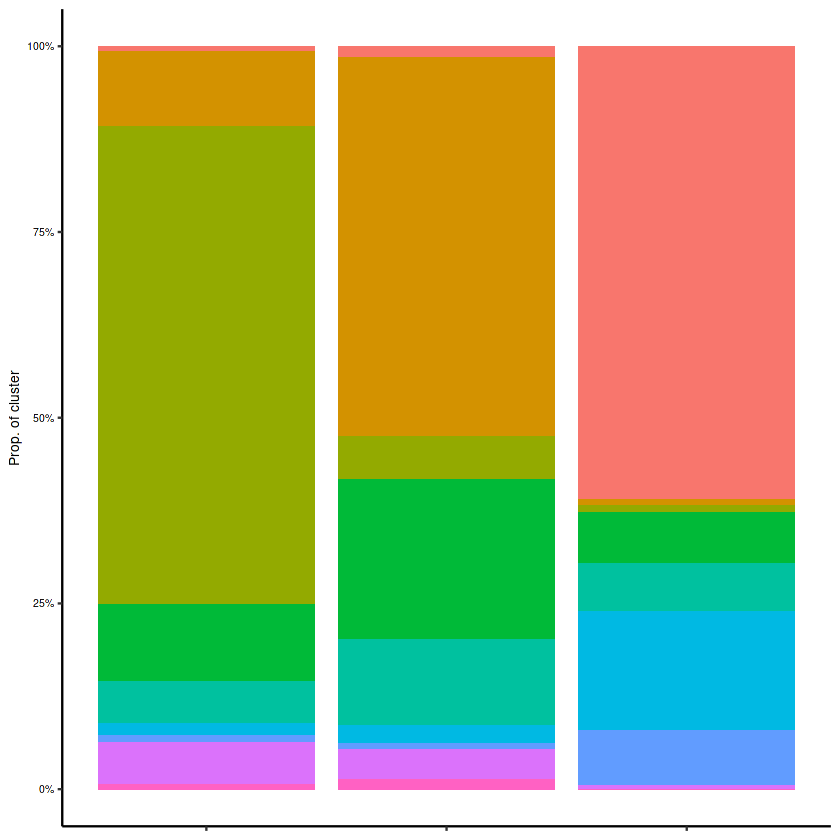

In [28]:
###S2C: Plot bar graph for cluster distribution
sample.name <- "Pooled"
dir.name <- "results/plotting/3F.PlotTreatment"
dir.output <- "results/plotting/S2C.Treat.Distribution"
red.use <- "umap" #dimentional reduction used
columns <- c("Control", "aPDL1", "aCD4")

##################### Processing layer #############################################################
dir.create(dir.output)
   
#Load data
name.input <- str_c(dir.name, sep = "/") %>% str_c("Treat.distribution.summary.csv", sep = "/")
data <- read.csv(name.input)
    
###Plot bar graph for cluster distribution
Cluster_bar(seu, red.use, data, dir.output, sample.name, columns, 1.2, 1)

Warning message in dir.create(dir.output):
“'results/plotting/S2D.OligoPoly.Distribution' already exists”


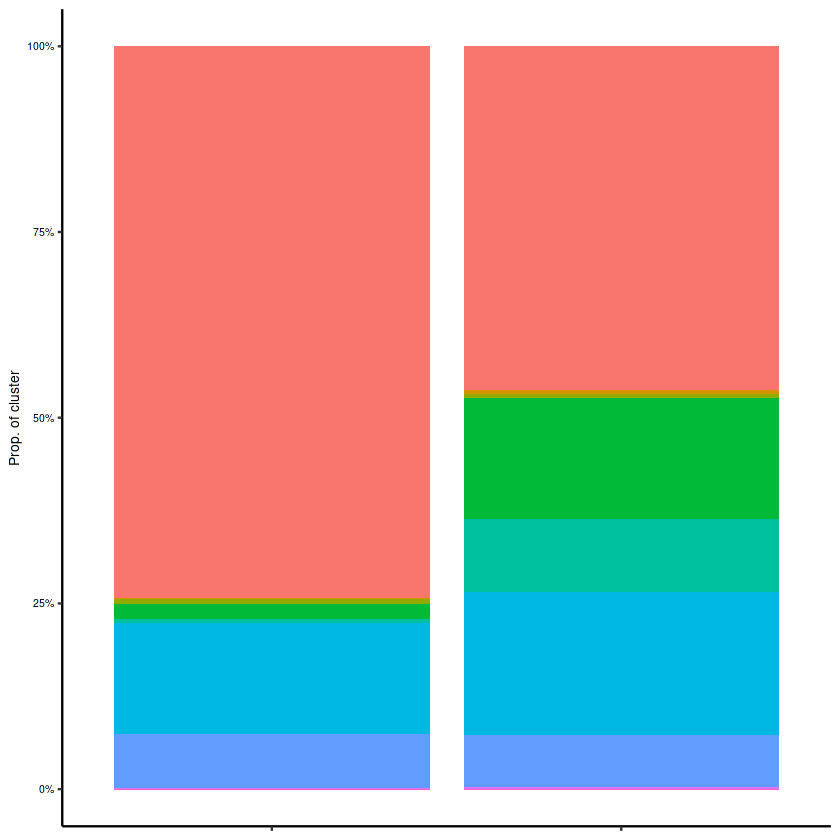

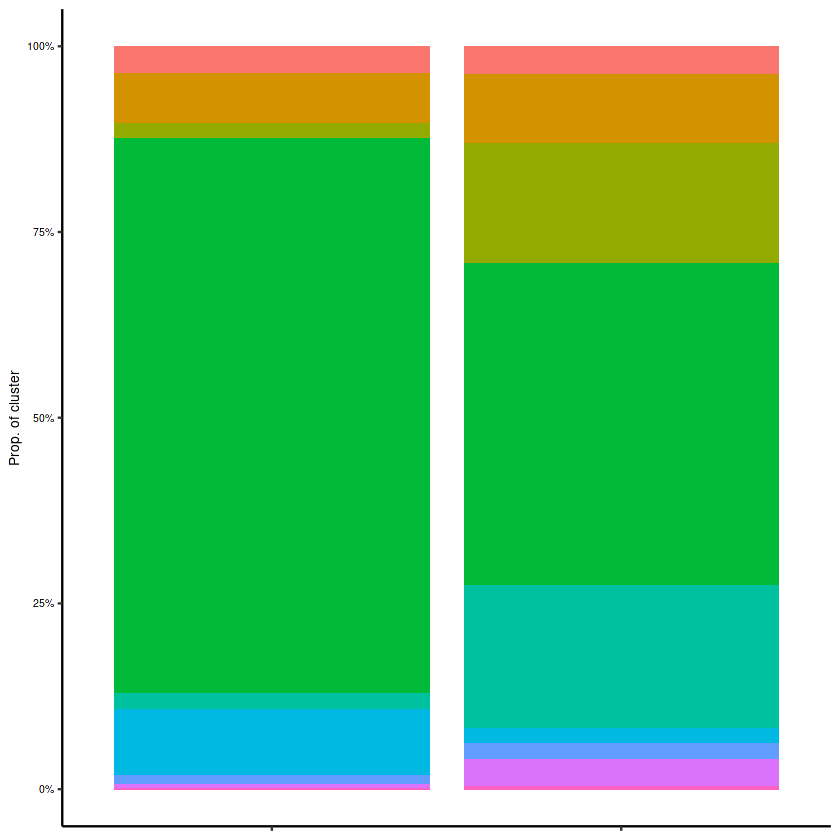

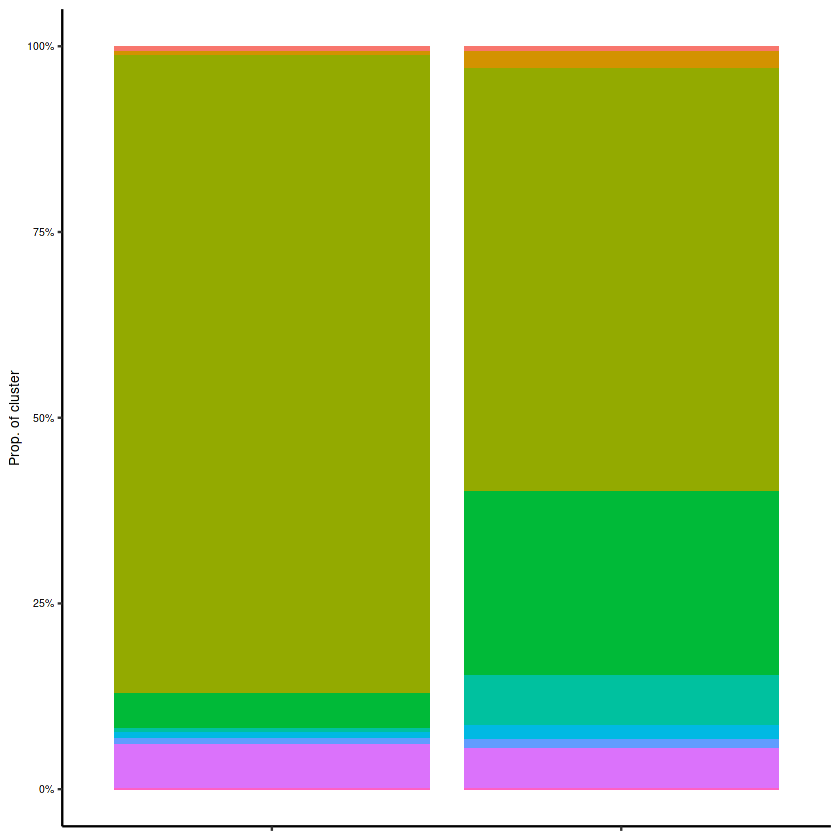

In [30]:
###S2D: Plot cluster distribution Oligoclonal / Polyclonal fraction

modules <- c("Oligo", "Poly")
treats <- c("aCD4", "aPDL1", "Control")
dir.output <- "results/plotting/S2D.OligoPoly.Distribution"
sample.name <- ""

############################# Processing layer ######################################
dir.create(dir.output)
for(treat in treats){
    #Call clone table merged with dLN overlap status (Stored in "scTCR_WGCNA_combine" directory)
    name.clone.input <- str_c("results/preprocess/scTCR_analysis", treat, sep = "/") %>% str_c("scTCR.dLNOL.csv", sep = ".")
    clone_within_cluster <- read.csv(name.clone.input, header = TRUE)
        
    #Generate table for distribution plot 
    clone_within_cluster <- dplyr::filter(clone_within_cluster, OL != "nonOL")
    table <- dplyr::filter(clone_within_cluster, treat == treat) %>% dplyr::select(starts_with("X"))
    clusts <- names(table)
    table$OL <- clone_within_cluster$OL
    data <- as.data.frame(dplyr::group_by(table, OL) %>% dplyr::summarize(dplyr::across(clusts, sum)))
        
    sample.name2 <- str_c(sample.name, treat)
        
    ###Plot bar graph for cluster distribution
    columns <- c("Oligo", "Poly")
    Cluster_bar(seu, red.use, data, dir.output, sample.name2, columns, 1, 1)
}